## Final Project Submission

Please fill out:
* Student name: Sung Hoon Bae
* Student pace: Full Time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:


In [ ]:
import pickle
def save_data(data, name):
    with open(name, 'wb') as f:
        pickle.dump(data, f)

def load_data(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

# EDA

In [4]:
# Import necessary libraries needed to EDA.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [ ]:
# Importing Dataset
X = pd.read_csv('datasets/Tanzanian/training_set.csv')
y = pd.read_csv('datasets/Tanzanian/train_result.csv')

# Converts functional wells into 1 and non-functional ones into 0.
# y['status_group'] = y['status_group'].apply(lambda x: 1 if x=='functional' else 0)

# Import the data and make sure it has loaded well
X.shape

In [49]:
def get_percent_retained(df):
    original_length = 59400
    print(f'Original Length: {original_length}')
    print(f'Current Length: {df.shape[0]}')
    print(f'Percent Retained: {round(df.shape[0]/original_length * 100, 2)}%')

## Feature Engineering Try #1


<AxesSubplot:>

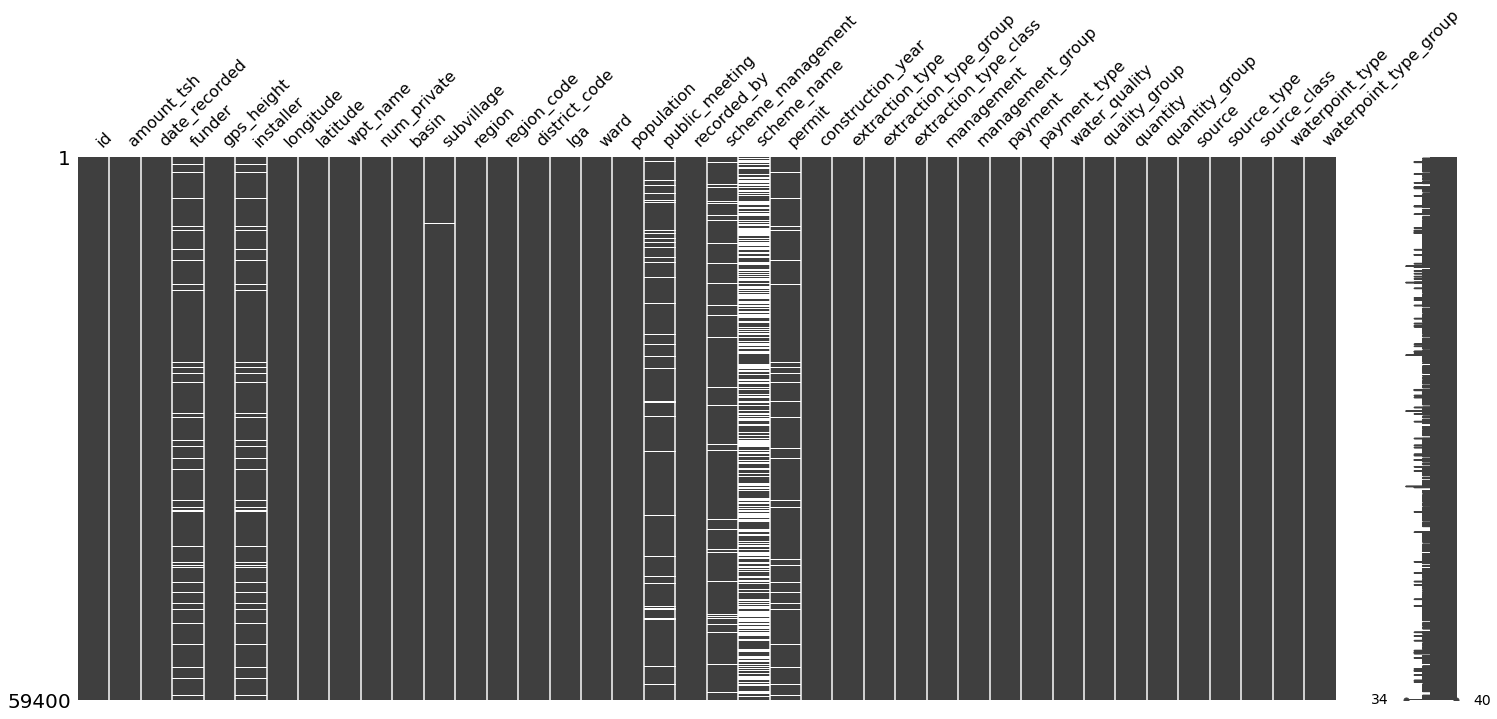

In [6]:
import missingno as ms
ms.matrix(X)

In [7]:
X.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

### Columns to drop

In [8]:
cols_to_drop = ['amount_tsh',
 'num_private',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'recorded_by',
 'extraction_type_group',
 'extraction_type_class',
 'payment',
 'water_quality',
 'source_type',
 'quantity_group',
 'waterpoint_type',
 'scheme_name']

In [9]:
X.drop(columns=cols_to_drop, inplace=True)

### Takes care of datetime

In [10]:
X['date_recorded'] = pd.to_datetime(X['date_recorded'])
X['year_recorded'] = X['date_recorded'].apply(lambda x: x.year)
X['month_recorded'] = X['date_recorded'].apply(lambda x: x.month)
X.drop(columns=['date_recorded'], axis=1, inplace=True)

In [11]:
X.head()

,id,funder,gps_height,installer,longitude,latitude,wpt_name,region_code,district_code,population,...,management,management_group,payment_type,quality_group,quantity,source,source_class,waterpoint_type_group,year_recorded,month_recorded
0,69572,Roman,1390,Roman,34.938093,-9.856322,none,11,5,109,...,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,2011,3
1,8776,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,20,2,280,...,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,2013,3
2,34310,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,21,4,250,...,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe,2013,2
3,67743,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,90,63,58,...,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe,2013,1
4,19728,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,18,1,0,...,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,2011,7


### wpt_name into a boolean column

In [12]:
# 1 if a name exists and 0 if not.
X['wpt_name'] = X['wpt_name']!='none'

In [13]:
X.isna().sum()

id                          0
funder                   3635
gps_height                  0
installer                3655
longitude                   0
latitude                    0
wpt_name                    0
region_code                 0
district_code               0
population                  0
public_meeting           3334
scheme_management        3877
permit                   3056
construction_year           0
extraction_type             0
management                  0
management_group            0
payment_type                0
quality_group               0
quantity                    0
source                      0
source_class                0
waterpoint_type_group       0
year_recorded               0
month_recorded              0
dtype: int64

## Dropping missing rows

In [15]:
# Dropping rows with missing values
df = pd.concat([X, y], axis=1)
df.head()

,id,funder,gps_height,installer,longitude,latitude,wpt_name,region_code,district_code,population,...,payment_type,quality_group,quantity,source,source_class,waterpoint_type_group,year_recorded,month_recorded,id,status_group
0,69572,Roman,1390,Roman,34.938093,-9.856322,False,11,5,109,...,annually,good,enough,spring,groundwater,communal standpipe,2011,3,69572,functional
1,8776,Grumeti,1399,GRUMETI,34.698766,-2.147466,True,20,2,280,...,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,2013,3,8776,functional
2,34310,Lottery Club,686,World vision,37.460664,-3.821329,True,21,4,250,...,per bucket,good,enough,dam,surface,communal standpipe,2013,2,34310,functional
3,67743,Unicef,263,UNICEF,38.486161,-11.155298,True,90,63,58,...,never pay,good,dry,machine dbh,groundwater,communal standpipe,2013,1,67743,non functional
4,19728,Action In A,0,Artisan,31.130847,-1.825359,True,18,1,0,...,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,2011,7,19728,functional


<AxesSubplot:>

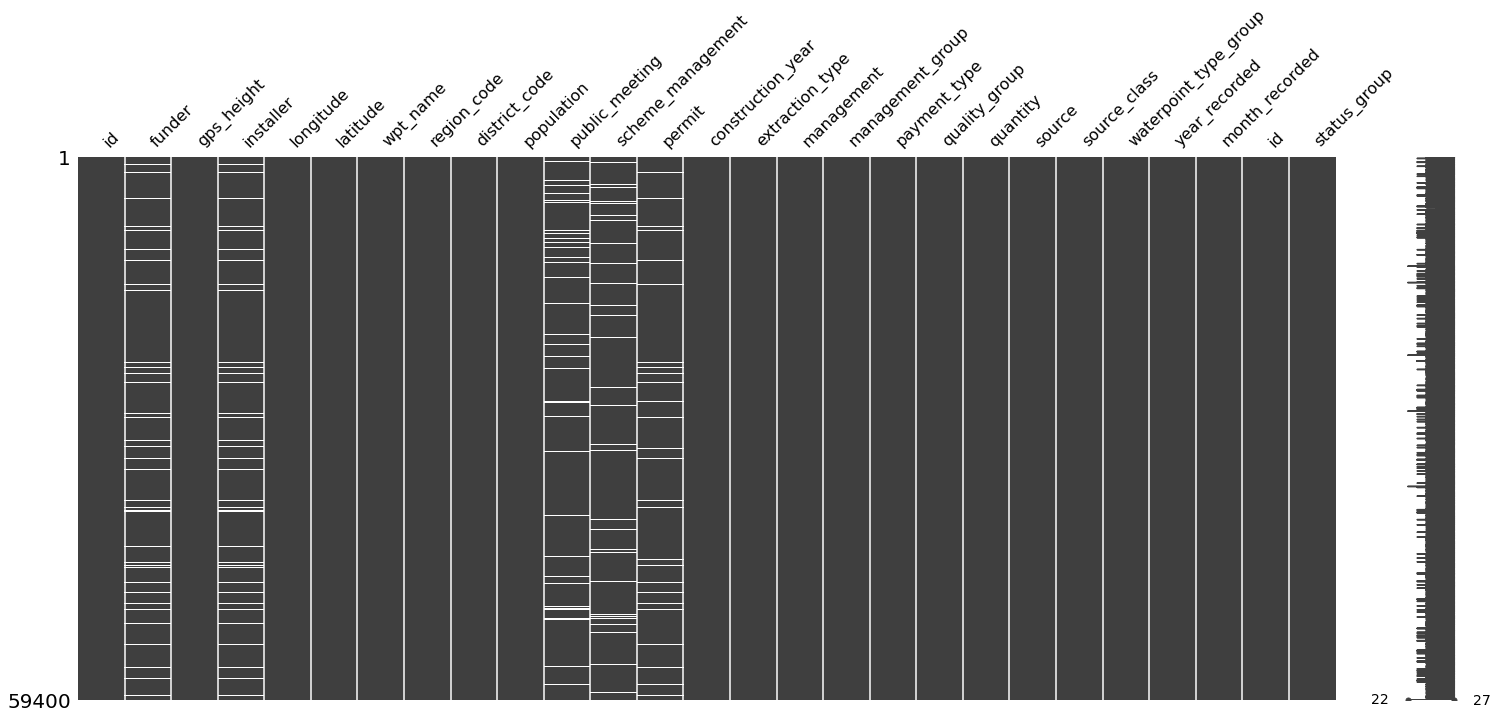

In [16]:
# missing values
ms.matrix(df)

In [46]:
df = drop_rows_na(df, 'public_meeting')
df = drop_rows_na(df, 'permit')

In [45]:
def drop_rows_na(df, col):
    indices = df[col].dropna().index
    return df.loc[indices,:]

<AxesSubplot:>

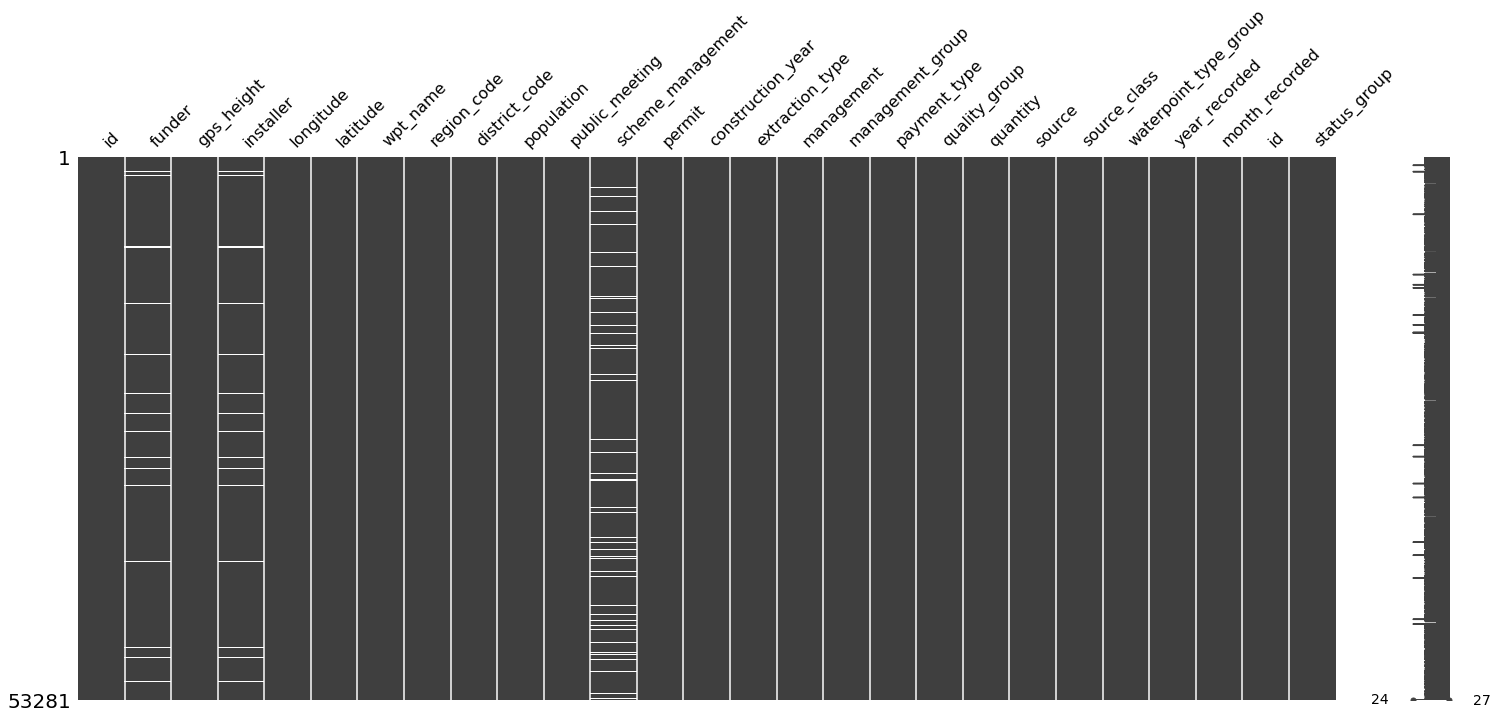

In [47]:
ms.matrix(df)

In [50]:
get_percent_retained(df)

Original Length: 59400
Current Length: 53281
Percent Retained: 89.7%


## Cat vs Num columns

In [52]:
# Categorical Columns
cat_cols = X.select_dtypes('O').columns
# Numerical Columsn
num_cols = X.select_dtypes(include=['float64', 'int64']).columns

In [53]:
cat_cols = list(cat_cols)
num_cols = list(num_cols)

In [54]:
num_cols.remove('id')

In [55]:
num_cols

['gps_height',
 'longitude',
 'latitude',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'year_recorded',
 'month_recorded']

# Vanilla Models

## Splitting Data

In [56]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [81]:
X = df.drop(columns=['status_group'], axis=1)
y = df['status_group']

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## Setting pipeline

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import set_config
set_config(display='diagram')

In [107]:
pipe_cat = Pipeline(steps=[('imp', SimpleImputer(strategy='constant', fill_value='MISSING')),
                           ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

pipe_num = Pipeline(steps=[('imp', SimpleImputer(missing_values=0, strategy='median')),
                           ('scale', StandardScaler())])

In [108]:
preprocessing = ColumnTransformer(transformers=[
    ('cat', pipe_cat, cat_cols),
    ('num', pipe_num, num_cols)
])
preprocessing

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['funder', 'installer', 'public_meeting',
                                  'scheme_management', 'permit',
                                  'extraction_type', 'management',
                                  'management_group', 'payment_type',
                                  'quality_group', 'quantity', 'source',
                                  'source_class', 'waterpoint_type_group']),
                                ('num',
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(missing_values=0,
                                                                strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['gps_height', 'longitude', 'latitude',
                                  'region_code', 'district_code', 'population',
                                  'construction_year', 'year_recorded',
                                  'month_recorded'])])

In [113]:
X_train_tf = preprocessing.fit_transform(X_train)
X_test_tf = preprocessing.transform(X_test)

In [110]:
feature_names = preprocessing.named_transformers_['cat'].\
                named_steps['encoder'].get_feature_names(cat_cols).tolist()
feature_names

features = feature_names+num_cols

['funder_0',
 'funder_A/co Germany',
 'funder_Aar',
 'funder_Abas Ka',
 'funder_Abasia',
 'funder_Abc-ihushi Development Cent',
 'funder_Abd',
 'funder_Abdul',
 'funder_Abood',
 'funder_Abs',
 'funder_Aco/germany',
 'funder_Acord',
 'funder_Acord Ngo',
 'funder_Acra',
 'funder_Action Aid',
 'funder_Action Contre La Faim',
 'funder_Action In A',
 'funder_Adap',
 'funder_Adb',
 'funder_Adf',
 'funder_Adp',
 'funder_Adp Bungu',
 'funder_Adp Mombo',
 'funder_Adp/w',
 'funder_Adra',
 'funder_Af',
 'funder_Africa',
 'funder_Africa Amini Alama',
 'funder_Africa Project Ev Germany',
 'funder_African',
 'funder_African 2000 Network',
 'funder_African Barrick Gold',
 'funder_African Development Bank',
 'funder_African Development Foundation',
 'funder_African Muslim Agency',
 'funder_African Realief Committe Of Ku',
 'funder_African Reflections Foundation',
 'funder_African Relie',
 'funder_Africaone Ltd',
 'funder_Africare',
 'funder_Afriican Reli',
 'funder_Agape Churc',
 'funder_Agt Church',


In [114]:
X_train_tf = pd.DataFrame(X_train_tf, columns = features)
X_test_tf = pd.DataFrame(X_test_tf, columns = features)

## Evaluating Classifier Model

In [118]:
import sklearn.metrics as metrics

def evaluate_classification(model,X_test,y_test,classes=None,
                           normalize='true',cmap='Purples',label=''):
    """Accepts an sklearn-compatible classification model + test data 
    and displays several sklearn.metrics functions: 
    - classifciation_report
    - plot_confusion_matrix
    - plot_roc_curve
    """
     
    ## Get Predictions
    y_hat_test = model.predict(X_test)
    
    
    ## Classification Report / Scores 
    table_header = "[i] CLASSIFICATION REPORT"
    
    ## Add Label if given
    if len(label)>0:
        table_header += f" {label}"
        
    
    ## PRINT CLASSIFICATION REPORT
    dashes = '---'*20
    print(dashes,table_header,dashes,sep='\n')

    print(metrics.classification_report(y_test,y_hat_test,
                                    target_names=classes))
    
    report = metrics.classification_report(y_test,y_hat_test,
                                               target_names=classes,
                                          output_dict=True)
    print(dashes+"\n\n")
    
    

    ## MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    ## Plot Confusion Matrix 
    metrics.plot_confusion_matrix(model, X_test,y_test,
                                  display_labels=classes,
                                  normalize=normalize,
                                 cmap=cmap,ax=axes[0])
    axes[0].set(title='Confusion Matrix')
    
    ## Plot Roc Curve
#     roc_plot = metrics.plot_roc_curve(model, X_test, y_test,ax=axes[1])
#     axes[1].legend()
#     axes[1].plot([0,1],[0,1],ls=':')
#     axes[1].grid()
#     axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
    fig.tight_layout()
    plt.show()
    
    return report #fig,axes

## Round 1 models

### Random Tree Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_tf, y_train)

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
                         precision    recall  f1-score   support

             functional       0.81      0.88      0.84      8712
functional needs repair       0.49      0.32      0.39      1131
         non functional       0.83      0.78      0.81      6142

               accuracy                           0.80     15985
              macro avg       0.71      0.66      0.68     15985
           weighted avg       0.79      0.80      0.80     15985

------------------------------------------------------------




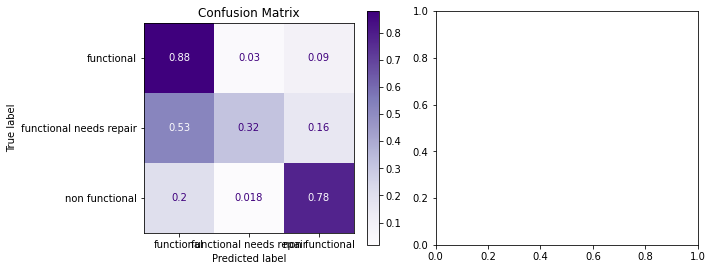

{'functional': {'precision': 0.8062887790514249,
  'recall': 0.8800505050505051,
  'f1-score': 0.8415564458591734,
  'support': 8712},
 'functional needs repair': {'precision': 0.4897680763983629,
  'recall': 0.31741821396993813,
  'f1-score': 0.3851931330472103,
  'support': 1131},
 'non functional': {'precision': 0.8331882291485286,
  'recall': 0.7790621947248453,
  'f1-score': 0.8052166596550274,
  'support': 6142},
 'accuracy': 0.8014388489208633,
 'macro avg': {'precision': 0.7097483615327721,
  'recall': 0.6588436379150961,
  'f1-score': 0.6773220795204704,
  'support': 15985},
 'weighted avg': {'precision': 0.7942294426607961,
  'recall': 0.8014388489208633,
  'f1-score': 0.795303967056784,
  'support': 15985}}

In [119]:
evaluate_classification(rf, X_test_tf, y_test);

### Decision Tree

In [122]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier()

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
                         precision    recall  f1-score   support

             functional       0.80      0.80      0.80      8712
functional needs repair       0.35      0.35      0.35      1131
         non functional       0.76      0.77      0.76      6142

               accuracy                           0.75     15985
              macro avg       0.64      0.64      0.64     15985
           weighted avg       0.75      0.75      0.75     15985

------------------------------------------------------------




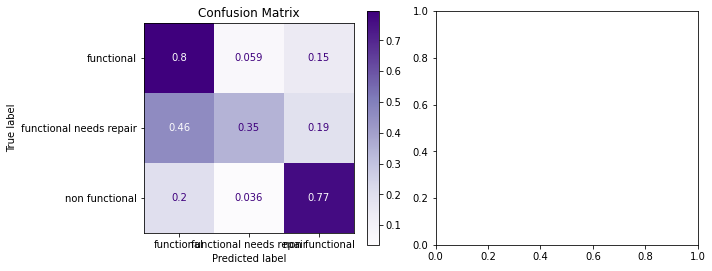

In [123]:
evaluate_classification(tree, X_test_tf, y_test);

### XGBoost classifier

In [129]:
temp_col_names = [f'x{i}' for i in range(len(X_train_tf.columns))]
X_train_tf.columns = temp_col_names
X_train_tf

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x3135,x3136,x3137,x3138,x3139,x3140,x3141,x3142,x3143,x3144
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-1.656284,1.309648,0.163510,-0.626922,-0.283531,0.358732,-1.462892,-0.909296,-0.451299
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.726576,1.179567,0.316911,-0.626922,-0.485536,-0.498201,-1.658978,-0.909296,-0.117516
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.163571,0.056697,1.979848,0.204476,-0.384534,-0.178194,0.203844,0.134537,1.885176
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.680937,0.898987,0.758811,-0.682348,-0.384534,-0.285579,1.086234,1.178371,-0.785081
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.712699,-1.669802,0.841123,0.038196,-0.485536,0.573502,0.890147,1.178371,-0.785081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.163571,-0.848559,0.573369,-0.072657,-0.485536,-0.178194,0.203844,0.134537,1.885176
37292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-1.376764,0.951326,-0.113593,-0.571495,0.019477,-0.498201,-0.188329,-0.909296,-0.451299
37293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.385557,0.338054,-1.649573,-0.294363,-0.081526,-0.285579,1.184277,1.178371,-0.785081
37294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.979417,1.438973,0.135536,-0.626922,-0.081526,0.358732,-1.266805,-0.909296,-0.451299


In [130]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_tf, y_train)

XGBClassifier(objective='multi:softprob')

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
                         precision    recall  f1-score   support

             functional       0.72      0.94      0.81      8712
functional needs repair       0.55      0.09      0.15      1131
         non functional       0.85      0.61      0.71      6142

               accuracy                           0.75     15985
              macro avg       0.70      0.55      0.56     15985
           weighted avg       0.76      0.75      0.73     15985

------------------------------------------------------------




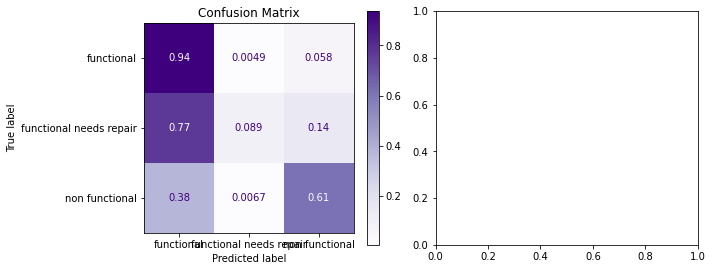

In [132]:
X_test_tf.columns = temp_col_names_col_names
evaluate_classification(xgb, X_test_tf, y_test);

In [133]:
X_train_tf.columns = features
X_test_tf.columns = features

### Adaboost classifier

In [125]:
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier()
ab.fit(X_train_tf, y_train)

AdaBoostClassifier()

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
                         precision    recall  f1-score   support

             functional       0.72      0.89      0.80      8712
functional needs repair       0.42      0.12      0.18      1131
         non functional       0.80      0.63      0.70      6142

               accuracy                           0.74     15985
              macro avg       0.64      0.55      0.56     15985
           weighted avg       0.73      0.74      0.72     15985

------------------------------------------------------------




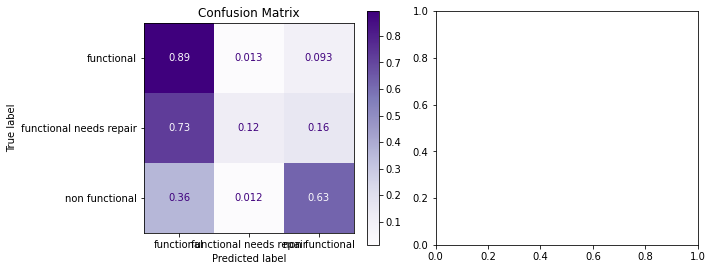

In [126]:
evaluate_classification(ab, X_test_tf, y_test);

### KNN Classifier

In [134]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_tf, y_train)

KNeighborsClassifier()

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
                         precision    recall  f1-score   support

             functional       0.72      0.89      0.80      8712
functional needs repair       0.42      0.12      0.18      1131
         non functional       0.80      0.63      0.70      6142

               accuracy                           0.74     15985
              macro avg       0.64      0.55      0.56     15985
           weighted avg       0.73      0.74      0.72     15985

------------------------------------------------------------




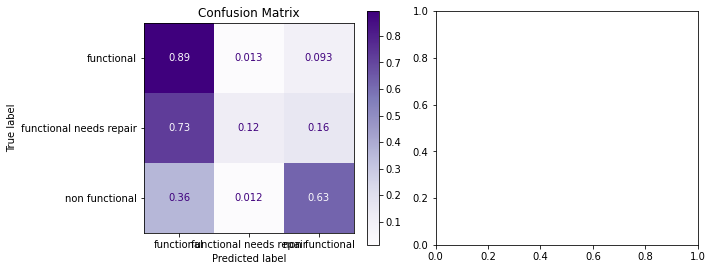

In [135]:
evaluate_classification(ab, X_test_tf, y_test);

### SVM Classifier

In [ ]:
import sklearn.svm as svm
sv = svm.SVC()
sv.fit(X_train_tf, y_train)

In [ ]:
evaluate_classification(sv, X_test_tf, y_test);

### Comparing all the models Round #1

In [ ]:
models_1 = [tree, rf, xgb, ab, knn, sv]
model_names_1 = ['Decision Tree', 
                 'Random Forest',
                 'XGBoost',
                 'AdaBoost',
                 'K Nearest Neighbor',
                 'Support Vector Machine']

save_data(models_1, 'model_1')

In [ ]:
for model from models_1:
    

# Feature Engineering #2

In [ ]:
import math
def get_distance(x, y):
    pi = np.pi
    R = 6371 # Average Earth radius in km
    
    # converts to radians
    lat1 = x[0]*pi/180 
    lat2 = y[0]*pi/180
    long1 = x[1]*pi/180
    long2 = y[1]*pi/180

    # finds delta angles
    del_lat = lat1 - lat2
    del_long = long1 - long2
        
    # Source: https://www.movable-type.co.uk/
    a = np.sin(del_lat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(del_long/2)**2
    c = 2*np.arctan(np.sqrt(a)/np.sqrt(1-a))
    d= R*c # distance in km
        
    return d

In [ ]:
for index, row in df.head().iterrows():
    print(index, row['latitude'], row['longitutde'])

In [ ]:
with open('datasets/Tanzanian/TZ_state_1.geojson', 'r') as f:
    tz_states = json.load(f)

In [ ]:
state_id_map = {}
for feature in tz_states['features']:
    feature['id'] = feature['properties']['ID_1']
    state_id_map[feature['properties']['NAME_1']] = feature['id']
state_id_map['Dar es Salaam'] = 2
state_id_map.pop('Dar-Es-Salaam')

In [ ]:
state_id_map

In [ ]:
df['region_id'] = df['region'].apply(lambda x: state_id_map[x])

In [ ]:
df.keys()

In [ ]:
sns.scatterplot(x='construction_year', y='status_group', data=df)

In [ ]:
a = df[df['region']=='Kaskazini-Pemba']
a.shape

In [ ]:
df['source_class'].isna().sum()

In [ ]:
df_region = pd.DataFrame(dict(id=list(state_id_map.values()),region = list(state_id_map.keys())))
df_region

In [ ]:
total_nums = []
total_func = []
total_repair = []
total_non_func = []

main_source = []
main_source_perc = []

quantity = []
quantity_perc = []

for region in df_region['region']:
    df_copy = df[df['region']==region].copy()
    if df_copy.shape[0] != 0:
        total_num = df_copy.shape[0]
        # Total number of wells installed in the region
        total_nums.append(total_num)

        # Total number of wells that are functions, non functional, and needs repair
        total_func.append((df_copy['status_group'] == 'functional').sum())
        total_non_func.append((df_copy['status_group'] == 'non functional').sum())
        total_repair.append((df_copy['status_group'] == 'functional needs repair').sum())

        # main water source
        try:
            main_source.append(df_copy['source_class'].value_counts(normalize=True).index[0])
            main_source_perc.append(df_copy['source_class'].value_counts(normalize=True)[0])
        except:
            print(region)

        # water quantity
        quantity.append(df_copy['quantity'].value_counts(normalize=True).index[0])
        quantity_perc.append(df_copy['quantity'].value_counts(normalize=True)[0])
    else:
        total_nums.append(0)
        total_func.append(0)
        total_non_func.append(0)
        total_repair.append(0)
        
        main_source.append(0)
        main_source_perc.append(0)
        
        quantity.append(0)
        quantity_perc.append(0)

        

In [ ]:
df_region['total_nums'] = total_nums
df_region['total_func'] = total_func
df_region['total_repair'] = total_repair
df_region['total_non_func'] = total_non_func

df_region['main_source'] = main_source
df_region['main_source_perc'] = main_source_perc

df_region['quantity'] = quantity
df_region['quantity_perc'] = quantity_perc

In [ ]:
df_region['func_perc']=round(df_region['total_func']/df_region['total_nums']*100,2)
df_region['non_func_perc']=round(df_region['total_non_func']/df_region['total_nums']*100,2)
df_region['repair_perc']=round(df_region['total_repair']/df_region['total_nums']*100,2)


In [ ]:
df_region.dropna()

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'chrome'

In [ ]:
px.choropleth(df_region, locations='id', 
              geojson=tz_states, 
              hover_name = 'region',
              hover_data = ['func_perc', 'non_func_perc', 'repair_perc'],
              color='total_nums',
              scope='africa')